In [1]:
!which jupyter

/home/lcy/anaconda3/envs/strap/bin/jupyter


In [2]:
!nvidia-smi

Sun Jul 25 12:23:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:02:00.0 Off |                  N/A |
| 47%   72C    P2   286W / 270W |   1631MiB / 11178MiB |     65%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:03:00.0 Off |                  N/A |
| 22%   

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
import os, glob, json
import time
import numpy as np
import pandas as pd
import h5py
from PIL import Image
import random
from random import shuffle
import copy
import pickle
from math import ceil
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.models as models
import torch.nn.init as init

In [6]:
batchSize=32
imgSize=int(96)
num_classes = 2

In [7]:
import staintools

In [8]:
def get_stain_normalizer(path='/media/dnr/data_crypt/cy_strap/ref.png', method='macenko'):
    target = staintools.read_image(path)
    target = staintools.LuminosityStandardizer.standardize(target)
    normalizer = staintools.StainNormalizer(method=method)
    normalizer.fit(target)
    return normalizer

In [9]:
staintools.read_image('/media/dnr/data_crypt/cy_strap/ref.png').shape

(96, 96, 3)

In [10]:
def apply_stain_norm(tile, normalizer):
    to_transform = np.array(tile).astype('uint8')
    to_transform = staintools.LuminosityStandardizer.standardize(to_transform)
    transformed = normalizer.transform(to_transform)
#     transformed = Image.fromarray(transformed)
    return transformed

In [11]:
class stain_norm(object):
    def __call__(self, sample):
        sample = np.array(sample)
        normalizer = get_stain_normalizer()
        rgbaug = apply_stain_norm(sample, normalizer)
        return rgbaug

In [12]:
augment = transforms.Compose([stain_norm(),
                              transforms.ToPILImage(),
                              # transforms.Resize(imgSize),
                              transforms.RandomResizedCrop(imgSize),
                              transforms.RandomHorizontalFlip(p=0.5),
                              transforms.RandomVerticalFlip(p=0.5),
                              # transforms.RandomResizedCrop(imgSize, scale=(0.8, 1.0), ratio=(1, 1)),
                              transforms.ToTensor(),
                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize(imgSize),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [13]:
data_root_path = '/media/dnr/data_crypt/cy_strap/camelyon17_v1.0/patches'
csv_path = '/media/dnr/data_crypt/cy_strap/metadata_fnames_splits_modSplit.csv'

In [14]:
image_paths = glob.glob(f'{data_root_path}/*/*.png')
len(image_paths), image_paths[0]

(455954,
 '/media/dnr/data_crypt/cy_strap/camelyon17_v1.0/patches/patient_067_node_4/patch_patient_067_node_4_x_4544_y_30528.png')

In [15]:
df = pd.read_csv(csv_path); df.shape

(455954, 11)

In [16]:
df.head()

,Unnamed: 0,patient,node,x_coord,y_coord,tumor,slide,center,split,fnames,data_split
0,0,4,4,3328,21792,1,0,0,0,../data/patches/patient_004_node_4/patch_patie...,train
1,1,4,4,3200,22272,1,0,0,0,../data/patches/patient_004_node_4/patch_patie...,train
2,2,4,4,3168,22272,1,0,0,0,../data/patches/patient_004_node_4/patch_patie...,train
3,3,4,4,3328,21760,1,0,0,0,../data/patches/patient_004_node_4/patch_patie...,train
4,4,4,4,3232,22240,1,0,0,0,../data/patches/patient_004_node_4/patch_patie...,train


In [17]:
fnames = df.fnames.tolist(); len(fnames)

455954

In [18]:
filenames = []
origin = str('/media/dnr/data_crypt/cy_strap/camelyon17_v1.0')
for name in fnames:
    temp = str(name[7:])
    temp_path = origin + temp
    filenames.append(temp_path)

In [19]:
print(len(filenames))

455954


In [20]:
error = []
for i in range(len(filenames)):
    sample_ = Image.open(filenames[i])
    sample_ = np.array(sample_)
  
    if sample_.shape[2] == 4:
        sample_ = sample_[:,:,:3]
    elif sample_.shape[2] != 3:
        raise ValueError('image channel num is not 3')
   
    normalizer = get_stain_normalizer()
    try:
        rgbaug = apply_stain_norm(sample_, normalizer)
    except Exception as e:
        error.append(i)
        print(f'error_{i}_{e}')

error_201647_Empty tissue mask computed


/home/lcy/anaconda3/envs/strap/lib/python3.6/site-packages/staintools/stain_normalizer.py:41: RuntimeWarning: divide by zero encountered in true_divide
  source_concentrations *= (self.maxC_target / maxC_source)
/home/lcy/anaconda3/envs/strap/lib/python3.6/site-packages/staintools/stain_normalizer.py:41: RuntimeWarning: invalid value encountered in multiply
  source_concentrations *= (self.maxC_target / maxC_source)


error_258105_Empty tissue mask computed
error_258248_Empty tissue mask computed
error_258387_Empty tissue mask computed
error_258417_Empty tissue mask computed
error_258532_Empty tissue mask computed
error_258729_Empty tissue mask computed
error_258855_Empty tissue mask computed
error_259055_Empty tissue mask computed
error_259195_0-dimensional array given. Array must be at least two-dimensional
error_259616_Empty tissue mask computed
error_259898_0-dimensional array given. Array must be at least two-dimensional
error_260132_Empty tissue mask computed
error_260141_Empty tissue mask computed
error_260240_Empty tissue mask computed
error_260486_Empty tissue mask computed
error_260514_Empty tissue mask computed
error_260547_Empty tissue mask computed
error_261295_Empty tissue mask computed
error_261511_Empty tissue mask computed
error_261686_Empty tissue mask computed
error_261848_Empty tissue mask computed
error_261891_Empty tissue mask computed
error_262245_Empty tissue mask computed
er

In [ ]:
# error, len(error)

In [ ]:
# import json
# with open("../data/error_stainNorm.txt", "w") as fp:
#     json.dump(error, fp)
# with open("../data/error_stainNorm.txt", "r") as fp:
#     error2 = json.load(fp)

In [20]:
data_root_path = '/media/dnr/data_crypt/cy_strap/camelyon17_v1.0/patches'
csv_path = '/media/dnr/data_crypt/cy_strap/metadata_fnames_splits_modSplit.csv'
error_path = '/media/dnr/data_crypt/cy_strap/error_stainNorm.txt'

In [21]:
class MyDataset(data.Dataset):
    def __init__(self, data_root_path=data_root_path, csv_path=csv_path, error_path=error_path, dset_type='train', transform=None):
        """
        dset_type: ["train", "val", "test"]
        """

        df = pd.read_csv(csv_path)
        with open(error_path, "r") as fp:
            error = json.load(fp)
        df = df.drop(df.index[error])

        self.df = df[df.data_split==dset_type]
        origin = str('/media/dnr/data_crypt/cy_strap/camelyon17_v1.0')
        temp_fnames = self.df.fnames.tolist()
        temp = []
        for name in temp_fnames:
            t = str(name[7:])
            temp_path = origin + t
            temp.append(temp_path)
        self.fnames = temp
        self.labels = self.df.tumor.tolist()
        self.transform=transform

    def __getitem__(self, index):
        fname = self.fnames[index]
        label = self.labels[index]
        img = np.array(Image.open(fname), dtype='uint8')
        
        if img.shape[2] == 4:
            img = img[:,:,:3]
        elif img.shape[2] != 3:
            raise ValueError('image channel num is not 3')
            
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.df)

In [22]:
datasets = {}
loaders = {}

for dset_type in ['train', 'val', 'test']:
    if dset_type == 'train':
        datasets[dset_type] = MyDataset(dset_type=dset_type, transform = augment)
        loaders[dset_type] = torch.utils.data.DataLoader(datasets[dset_type], batch_size=batchSize, shuffle=True, num_workers=4, pin_memory=True)
    elif dset_type == 'val':
        datasets[dset_type] = MyDataset(dset_type=dset_type, transform = transform)
        loaders[dset_type] = torch.utils.data.DataLoader(datasets[dset_type], batch_size=batchSize, shuffle=True, num_workers=4, pin_memory=True)
    elif dset_type == 'test':
        datasets[dset_type] = MyDataset(dset_type=dset_type, transform = transform)
        loaders[dset_type] = torch.utils.data.DataLoader(datasets[dset_type], batch_size=batchSize, shuffle=False, num_workers=4, pin_memory=True)
    print('Finished loading %s dataset: %s samples' % (dset_type, len(datasets[dset_type])))

Finished loading train dataset: 333715 samples
Finished loading val dataset: 37018 samples
Finished loading test dataset: 85050 samples


In [23]:
def get_model(num_classes):

#     model = models.mobilenet_v2(pretrained=True)
#     model.classifier = nn.Sequential(nn.Dropout(p=0.2), nn.Linear(1280, num_classes))
    
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.classifier = nn.Sequential(nn.Dropout(p=0.2), nn.Linear(num_ftrs, num_classes))
    
    return model

In [24]:
def train_model(model, loaders, criterion, optimizer, scheduler, num_epochs=40, estop=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float("inf")
    counter = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            ##########
            
#             while True:
#                 try:
#                     inputs, labels = next(loaders[phase])

#                     inputs = inputs.to(device)
#                     labels = labels.to(device)

#                     optimizer.zero_grad()

#                     with torch.set_grad_enabled(phase == 'train'):
#                         outputs = model(inputs)
#                         _, preds = torch.max(outputs, 1)
#                         loss = criterion(outputs, labels)

#                         if phase == 'train':
#                             loss.backward()
#                             optimizer.step()

#                     running_loss += loss.item() * inputs.size(0)
#                     running_corrects += torch.sum(preds == labels.data)
                
#                 except:
#                     pass

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val':
                if scheduler is not None:
                    scheduler.step(epoch_loss)
                    
                if epoch_loss < best_loss:
                    best_epoch = epoch
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    counter = 0
                else:
                    counter += 1

        print()

        if counter >= estop:
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best val Loss: {:4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)

    return model, best_loss, best_acc, best_epoch

In [25]:
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [ ]:
model = get_model(num_classes)
model = model.to('cuda')

params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = optim.SGD(params_to_update, lr=0.004, momentum=0.9, nesterov=True)
criterion = nn.CrossEntropyLoss()

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val', 'test']}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model, best_loss, best_acc, best_epoch = \
    train_model(model, loaders, criterion, optimizer, scheduler=None, num_epochs=40, estop=5)
torch.save(model.state_dict(), 'state_dicts/wilds_stain_normalization_res50_modSplit4.pth')

Epoch 0/39
----------


In [ ]:
warnings.filterwarnings('default')

In [ ]:
def test_model(model, loader, dataset_size, criterion):
    
    print('-' * 10)
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    whole_probs = torch.FloatTensor(dataset_size)
    whole_labels = torch.LongTensor(dataset_size)
    
    with torch.no_grad():

        # Iterate over data.
        for i, data in enumerate(loader):
            inputs = data[0].to(device)
            labels = data[1].to(device)

            # forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            outputs = F.softmax(outputs, dim=1)
            whole_probs[i*batchSize:i*batchSize+inputs.size(0)]=outputs.detach()[:,1].clone()
            whole_labels[i*batchSize:i*batchSize+inputs.size(0)]=labels.detach().clone()

        total_loss = running_loss / dataset_size
        total_acc = running_corrects.double() / dataset_size

    print('Test Loss: {:.4f} Acc: {:.4f}'.format(total_loss, total_acc))

    return whole_probs.cpu().numpy(), whole_labels.cpu().numpy(), total_loss, total_acc

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import roc_curve, auc, roc_auc_score

/home/rikiya/miniconda3/envs/pytorch14/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/rikiya/miniconda3/envs/pytorch14/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/rikiya/miniconda3/envs/pytorch14/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [ ]:
from sklearn.metrics import roc_auc_score
def bootstrap_auc(y_true, y_pred, n_bootstraps=1000, rng_seed=42):
    n_bootstraps = n_bootstraps
    rng_seed = rng_seed  # control reproducibility
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(len(y_pred), size=len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue
        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
#         print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    bootstrapped_scores = np.array(bootstrapped_scores)

    print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
        np.percentile(bootstrapped_scores, (2.5, 97.5))[0], np.percentile(bootstrapped_scores, (2.5, 97.5))[1]))
    
    return np.percentile(bootstrapped_scores, (2.5, 97.5))[0], np.percentile(bootstrapped_scores, (2.5, 97.5))[1]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
prob_test, label_test, loss_test, acc_test = test_model(model, loaders['test'], dataset_sizes['test'], criterion)

----------
Test Loss: 1.8139 Acc: 0.6307


In [ ]:
pred_test = [1 if prob>0.50 else 0 for prob in prob_test]

In [ ]:
cm = confusion_matrix(label_test, pred_test)
print(cm)
acc = (cm[0][0]+cm[1][1])/len(pred_test)*100
print('accuracy = ' + str(acc))

[[42426    97]
 [31309 11218]]
accuracy = 63.07348618459729


In [ ]:
print(f'tile-wise AUC is {roc_auc_score(label_test, prob_test)}')

tile-wise AUC is 0.8586156349206833


In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(label_test, prob_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
ci_low, ci_high = bootstrap_auc(np.array(label_test), np.array(prob_test))
print(f'AUROC = {roc_auc} with 95CI of {ci_low}-{ci_high}')

Confidence interval for the score: [0.856 - 0.861]
AUROC = 0.8586156349206833 with 95CI of 0.856144530524559-0.8610664114602331


Confusion matrix
[[42426    97]
 [31309 11218]]


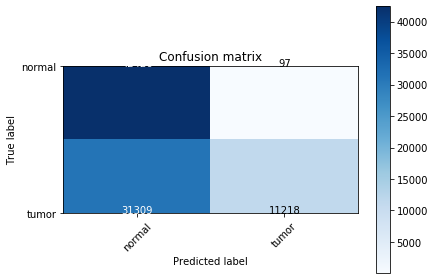

In [ ]:
plot_confusion_matrix(cm, classes=["normal", "tumor"])

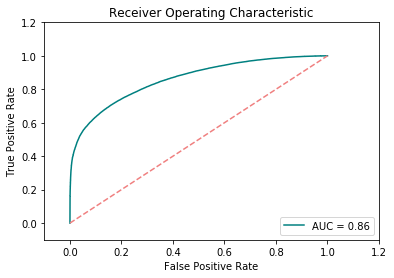

In [ ]:
plt.title("Receiver Operating Characteristic")
plt.plot(false_positive_rate, true_positive_rate, color="teal", label="AUC = %0.2f" % roc_auc)
plt.legend(loc="lower right")
plt.plot([0,1],[0,1], color="lightcoral", ls="--")
plt.xlim([-0.1, 1.2])
plt.ylim([-0.1, 1.2])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()